# DQN


### Training of DQN in Tensorflow
--------------------------

In [3]:
#
from util import *
from dlg_manager import *
from alg import *
from agent import *
from user_sim import *
from state_tracker import *
import random
from config import *
import matplotlib.pyplot as plt
import numpy as np
from nlg import *
from six.moves import cPickle as pickle
import IPython
import copy, argparse, json

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data
-------------------

#### Action Set

In [4]:
#
act_set_path = './data/dia_acts.txt'
act_set = text_to_dict(act_set_path)
sample_dict(act_set)

keys = 11
Sample of dict:
- request: 0
- welcome: 8
- inform: 1
- confirm_answer: 3
- deny: 9


### slot set

In [5]:
#
slots_set_path = "./data/slot_set.txt"
slot_set = text_to_dict(slots_set_path)
sample_dict(slot_set)

keys = 29
Sample of dict:
- theater: 22
- movie_series: 11
- result: 26
- theater_chain: 23
- closing: 3


### movie dic: info about movie

In [6]:
#
movie_kb_path = "./data/movie_kb.1k.p"
movie_kb = pickle.load(open(movie_kb_path, 'rb'), encoding="latin")
sample_dict(movie_kb, sample_size=1)

keys = 991
Sample of dict:
- 433: {'city': 'birmingham', 'theater': 'carmike summit 16', 'critic_rating': '6', 'date': 'friday', 'state': 'al', 'other': 'imdb', 'starttime': 'matinee', 'genre': 'action', 'moviename': 'deadpool'}


# Language Generator (pretrained)
-------------------

In [7]:
#
nlg_model_path = './data/trained_model/nlg/lstm_tanh_relu_[1468202263.38]_2_0.610.p'
nlg_model = Nlg()
nlg_model.load_nlg_model(nlg_model_path)
diaact_nl_pairs_path = "./data/nlg/dia_act_nl_pairs.v6.json"
nlg_model.load_predefine_act_nl_pairs(diaact_nl_pairs_path)

## Model Params

In [8]:
#
model_params = pickle.load(open(nlg_model_path, 'rb'), encoding='latin1')
params = model_params['params']
params['batch_size'] = 16
batch_size = 16
save_check_point = 20
params['trained_model_path'] = None
for k in params:
    print("{}: {}".format(k, params[k]))

grad_clip: -0.0001
dia_slot_val: 2
reg_cost: 0.001
data_path: .\data\movieMultiLine.Annot.Corrected.Final.v3.csv
save_check_point: 20
slot_rep: 1
max_epochs: 200
sdgtype: rmsprop
init_rnn: 0
cv_fold: 6
write_model_dir: .\checkpoints\template\07102016\
valid_test: 0
pretrained_model_path: None
check_point: 20
decay_rate: 0.999
feed_recurrence: 0
hidden_size: 100
activation_func: relu
momentum: 0.1
learning_rate: 0.001
batch_size: 16
act_set: data/dia_acts.txt
smooth_eps: 1e-08
split_method: 1
slot_set: data/slot_set.txt
eva_metric: 2
model: lstm_tanh
trained_model_path: None


# User Simulator
-------------------

### goal

In [9]:
#
goal_file_path = './data/user_goals_first_turn_template.part.movie.v1.p'
all_goal_set = pickle.load(open(goal_file_path, 'rb'), encoding="latin")
print("goals length: {}".format(len(all_goal_set)))
print("Sample the first goal: \n{}".format(all_goal_set[0]))

goals length: 128
Sample the first goal: 
{'request_slots': {}, 'diaact': 'request', 'inform_slots': {'city': 'birmingham', 'numberofpeople': '1', 'theater': 'carmike summit 16', 'state': 'al', 'starttime': 'around 2pm', 'date': 'today', 'moviename': 'zootopia'}}


### Split goal set

In [10]:
# split goal set
split_fold = params.get('split_fold', 5)
goal_set = {'train':[], 'valid':[], 'test':[], 'all':[]}
for u_goal_id, u_goal in enumerate(all_goal_set):
    if u_goal_id % split_fold == 1: goal_set['test'].append(u_goal)
    else: goal_set['train'].append(u_goal)
    goal_set['all'].append(u_goal)
print(len(goal_set['train']))
print(len(goal_set['valid']))
print(len(goal_set['test']))
print(len(goal_set['all']))

102
0
26
128


### user simulator param

In [11]:
#
usersim_params = {}
usersim_params['max_turn'] = 40
usersim_params['slot_err_prob'] = 0.00
# slot_err_mode: 0 for slot_val only; 1 for three errs
usersim_params['slot_err_mode'] = 0
usersim_params['intent_err_prob'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
usersim_params['run_mode'] = 0
# 0 for dia_act level; 1 for NL level
usersim_params['act_level'] = 0
# train/test/all; default is all
usersim_params['learn_phase'] = 'all'

### a movie dictionary for user simulator - slot:possible values

In [12]:
#
movie_dict_path = './data/user/dicts.v3.p'
movie_dictionary = pickle.load(open(movie_dict_path, 'rb'), encoding="latin")
samples = sample_dict(movie_dictionary, sample_size=1)

keys = 20
Sample of dict:
- theater: ['manville 12 plex', 'amc dine-in theatres bridgewater 7', 'bridgewater', 'every single theatre', 'bellevue lincoln square cinemas', 'regal meridian 16', 'regal meridian', 'carmike summit 16', 'carmike summit', 'century centre 9', 'Redwood City 20', 'many', 'amc pacific place 11 theater', 'regal lloyd center 10', 'carmike 16', 'river east 21', 'emagine theater', 'emagine', 'different', 'amc star john r 15', 'any', 'FLIX BREWHOUSE DES MOINES', 'CARMIKE COBBLESTONE 9', 'cinemas', 'regal visalia stadium 10', 'amc pacific place 11', 'amc loews boston common 19', 'amc showplace carbondale 8', 'amc lowes oak tree', 'amc lowes oak tree 6', 'royal oak emagine theater', 'Regal LA LIVE Stadium 14', 'regal la live stadium', 'Big Picture', 'Cinerama', 'Central Cinema', 'century rowland plaza', 'the century rowland plaza', 'regency commerce 14', 'bellevue lincoln square', 'amc west shore 14 210 Westshore Plaza', 'pacific science center imax theaters', 'carmike p

###  Create a User

In [13]:
user = RuleSimulator(movie_dictionary, act_set, slot_set, goal_set, usersim_params)
user.set_nlg_model(nlg_model)

# Agent
-------------------

## param

In [14]:
#
agent_params = {}
# maximum length of each dialog (default=20, 0=no maximum length)
agent_params['max_turn'] = 40
# Epsilon to determine stochasticity of epsilon-greedy agent policies
agent_params['epsilon'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
agent_params['agent_run_mode'] = 3
# 0 for dia_act level; 1 for NL level
agent_params['agent_act_level'] = 0

############### DQN #################
# the size for experience replay
agent_params['experience_replay_pool_size'] = 10000
# # the hidden size for DQN
agent_params['dqn_hidden_size'] = 60
agent_params['batch_size'] = 16
# # gamma for DQN
agent_params['gamma'] = 0.9
# # predict model for DQN
agent_params['predict_mode'] = True
agent_params['trained_model_path'] = params['pretrained_model_path']
#####################################
print("pretrained model path = {}".format(agent_params['trained_model_path']))
# 0: no warm start; 1: warm start for training
agent_params['warm_start'] = 1
# run_mode: 0 for NL; 1 for dia_act
agent_params['cmd_input_mode'] = 0

success_rate_threshold = 0.3

pretrained model path = None


### create an agent

In [15]:
# agent = RequestBasicsAgent(movie_kb, act_set, slot_set, agent_params)
# agent = AgentDQN(movie_kb, act_set, slot_set, agent_params)
# agt = 9
agt = 10
agent_params['batch_size']  = batch_size
if agt == 9:
    agent = AgentDQN(movie_kb, act_set, slot_set, agent_params)
else:
    agent = DQNAgentTF(movie_kb, act_set, slot_set, agent_params)

agent.set_nlg_model(nlg_model)

80


# Dialog Manager
-------------------

In [16]:
dlg_manager = DlgManager(agent, user, act_set, slot_set, movie_kb)

## Running Episodes
-------------------

### Param

In [17]:
#
status = {'successes': 0, 'count': 0, 'cumulative_reward': 0}
# the size of validation set
simulation_epoch_size = 100
# the number of epochs for warm start 
warm_start_epochs = 200
# num_episodes = 60

In [18]:
""" Warm_Start Simulation (by Rule Policy) """
def warm_start_simulation():
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(warm_start_epochs):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("warm_start simulation episode %s: Success" % (episode))
#                 else: print ("warm_start simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        if len(agent.experience_replay_pool) >= agent.experience_replay_pool_size:
            break
    
    agent.warm_start = 2
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print ("Warm_Start %s epochs, success rate %s, ave reward %s, ave turns %s" % (episode+1, res['success_rate'], res['ave_reward'], res['ave_turns']))
    print ("Current experience replay buffer size %s" % (len(agent.experience_replay_pool)))

In [19]:
def simulation_epoch(simulation_epoch_size):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(simulation_epoch_size):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("simulation episode %s: Success" % (episode))
#                 else: print ("simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
    
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print("simulation success rate %s, ave reward %s, ave turns %s" % (res['success_rate'], res['ave_reward'], res['ave_turns']))
    return res

In [20]:
def run_episodes(count, status):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    
    if agt >= 9 and params['trained_model_path'] == None and agent.warm_start == 1:
        print ('warm_start starting ...')
        warm_start_simulation()
        print ('warm_start finished, start RL training ...')
    
    for episode in range(count):
        print ("----------------- Episode: %s ----------------- " % (episode))
        dlg_manager.init_episode()
        episode_over = False
        
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
                
            if episode_over:
                if reward > 0:
                    print ("Successful Dialog!")
                    successes += 1
#                 else: print ("Failed Dialog!")
                
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        # simulation
        if agt >= 9 and params['trained_model_path'] == None:
            agent.predict_mode = True
            simulation_res = simulation_epoch(simulation_epoch_size)
            
            performance_records['success_rate'][episode] = simulation_res['success_rate']
            performance_records['ave_turns'][episode] = simulation_res['ave_turns']
            performance_records['ave_reward'][episode] = simulation_res['ave_reward']
            
            if simulation_res['success_rate'] >= best_res['success_rate']:
                if simulation_res['success_rate'] >= success_rate_threshold: # threshold = 0.30
                    agent.experience_replay_pool = [] 
                    simulation_epoch(simulation_epoch_size)
                
#             if simulation_res['success_rate'] > best_res['success_rate']:
#                 best_model['model'] = copy.deepcopy(agent)
#                 best_res['success_rate'] = simulation_res['success_rate']
#                 best_res['ave_reward'] = simulation_res['ave_reward']
#                 best_res['ave_turns'] = simulation_res['ave_turns']
#                 best_res['epoch'] = episode
                
            loss = agent.train(batch_size, 1)
            if agt == 10: 
                agent.model.update_target_params()
            else: 
                agent.clone_dqn = copy.deepcopy(agent.dqn)
                
            agent.predict_mode = False
            
            print ("Simulation success rate %s, Ave reward %s, Ave turns %s, Best success rate %s" % (performance_records['success_rate'][episode], performance_records['ave_reward'][episode], performance_records['ave_turns'][episode], best_res['success_rate']))
#             if episode % save_check_point == 0 and params['trained_model_path'] == None: # save the model every 10 episodes
#                 save_model(params['write_model_dir'], agt, best_res['success_rate'], best_model['model'], best_res['epoch'], episode)
#                 save_performance_records(params['write_model_dir'], agt, performance_records)
        curve.append(successes/(episode+1))
        losses.append(loss)
        print("Progress: %s / %s, Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (episode+1, count, successes, episode+1, float(cumulative_reward)/(episode+1), float(cumulative_turns)/(episode+1)))
    print("Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (successes, count, float(cumulative_reward)/count, float(cumulative_turns)/count))
    status['successes'] += successes
    status['count'] += count
    
#     if agt == 9 and params['traained_model_path'] == None:
#         save_model(params['write_model_dir'], agt, float(successes)/count, best_model['model'], best_res['epoch'], count)
#         save_performance_records(params['write_model_dir'], agt, performance_records)


## Run a Warm Start

# Train & Eval
-------------------

In [21]:
performance_records = {}
performance_records['success_rate'] = {}
performance_records['ave_turns'] = {}
performance_records['ave_reward'] = {}

best_model = {}
best_res = {'success_rate': 0, 'ave_reward':float('-inf'), 'ave_turns': float('inf'), 'epoch':0}

curve = []
losses = []
agent.warm_start = 1
run_episodes(400, status)

warm_start starting ...
Warm_Start 200 epochs, success rate 0.69, ave reward -11.2, ave turns 32.0
Current experience replay buffer size 1600
warm_start finished, start RL training ...
----------------- Episode: 0 ----------------- 
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 3721
- cur bellman err 12.6944, experience replay pool 3721
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 1 / 400, Success rate: 0 / 1 Avg reward: -60.00 Avg turns: 42.00
----------------- Episode: 1 ----------------- 
simulation success rate 0.0, ave reward -49.8, ave turns 21.6
Train on : 4801
- cur bellman err 7.7605, experience replay pool 4801
Simulation success rate 0.0, Ave reward -49.8, Ave turns 21.6, Best success rate 0
Progress: 2 / 400, Success rate: 0 / 2 Avg reward: -50.00 Avg turns: 22.00
----------------- Episode: 2 ----------------- 
simulation success rate 0.0, ave reward -59.64, ave turns 41.28
Train on : 6865
- cur bell

Successful Dialog!
simulation success rate 0.6, ave reward 21.46, ave turns 23.08
simulation success rate 0.58, ave reward 19.29, ave turns 22.62
Train on : 1131
- cur bellman err 6.1326, experience replay pool 1131
Simulation success rate 0.6, Ave reward 21.46, Ave turns 23.08, Best success rate 0
Progress: 24 / 400, Success rate: 4 / 24 Avg reward: -36.67 Avg turns: 35.33
----------------- Episode: 24 ----------------- 
simulation success rate 0.65, ave reward 29.43, ave turns 19.14
simulation success rate 0.59, ave reward 21.42, ave turns 20.76
Train on : 1038
- cur bellman err 8.6360, experience replay pool 1038
Simulation success rate 0.65, Ave reward 29.43, Ave turns 19.14, Best success rate 0
Progress: 25 / 400, Success rate: 4 / 25 Avg reward: -37.60 Avg turns: 35.60
----------------- Episode: 25 ----------------- 
Successful Dialog!
simulation success rate 0.54, ave reward 12.74, ave turns 26.12
simulation success rate 0.54, ave reward 11.87, ave turns 27.86
Train on : 1393
- 

simulation success rate 0.7, ave reward 35.16, ave turns 19.68
simulation success rate 0.69, ave reward 34.01, ave turns 19.58
Train on : 979
- cur bellman err 6.8776, experience replay pool 979
Simulation success rate 0.7, Ave reward 35.16, Ave turns 19.68, Best success rate 0
Progress: 44 / 400, Success rate: 17 / 44 Avg reward: -7.84 Avg turns: 30.41
----------------- Episode: 44 ----------------- 
Successful Dialog!
simulation success rate 0.82, ave reward 52.26, ave turns 14.28
simulation success rate 0.76, ave reward 43.85, ave turns 16.7
Train on : 835
- cur bellman err 8.2706, experience replay pool 835
Simulation success rate 0.82, Ave reward 52.26, Ave turns 14.28, Best success rate 0
Progress: 45 / 400, Success rate: 18 / 45 Avg reward: -6.00 Avg turns: 30.00
----------------- Episode: 45 ----------------- 
Successful Dialog!
simulation success rate 0.83, ave reward 52.87, ave turns 15.46
simulation success rate 0.82, ave reward 52.17, ave turns 14.46
Train on : 723
- cur be

Successful Dialog!
simulation success rate 0.85, ave reward 55.21, ave turns 15.58
simulation success rate 0.8, ave reward 48.73, ave turns 16.54
Train on : 827
- cur bellman err 4.7902, experience replay pool 827
Simulation success rate 0.85, Ave reward 55.21, Ave turns 15.58, Best success rate 0
Progress: 64 / 400, Success rate: 34 / 64 Avg reward: 12.09 Avg turns: 25.31
----------------- Episode: 64 ----------------- 
Successful Dialog!
simulation success rate 0.82, ave reward 51.22, ave turns 16.36
simulation success rate 0.86, ave reward 56.09, ave turns 16.22
Train on : 811
- cur bellman err 4.1722, experience replay pool 811
Simulation success rate 0.82, Ave reward 51.22, Ave turns 16.36, Best success rate 0
Progress: 65 / 400, Success rate: 35 / 65 Avg reward: 13.02 Avg turns: 25.20
----------------- Episode: 65 ----------------- 
simulation success rate 0.84, ave reward 54.02, ave turns 15.56
simulation success rate 0.87, ave reward 58.36, ave turns 14.08
Train on : 704
- cur 

simulation success rate 0.86, ave reward 56.46, ave turns 15.48
simulation success rate 0.82, ave reward 51.8, ave turns 15.2
Train on : 760
- cur bellman err 7.3101, experience replay pool 760
Simulation success rate 0.86, Ave reward 56.46, Ave turns 15.48, Best success rate 0
Progress: 84 / 400, Success rate: 49 / 84 Avg reward: 18.96 Avg turns: 24.07
----------------- Episode: 84 ----------------- 
Successful Dialog!
simulation success rate 0.84, ave reward 54.35, ave turns 14.9
simulation success rate 0.89, ave reward 60.7, ave turns 14.2
Train on : 710
- cur bellman err 3.8841, experience replay pool 710
Simulation success rate 0.84, Ave reward 54.35, Ave turns 14.9, Best success rate 0
Progress: 85 / 400, Success rate: 50 / 85 Avg reward: 19.62 Avg turns: 23.93
----------------- Episode: 85 ----------------- 
Successful Dialog!
simulation success rate 0.86, ave reward 57.48, ave turns 13.44
simulation success rate 0.75, ave reward 42.84, ave turns 16.32
Train on : 816
- cur bellm

simulation success rate 0.81, ave reward 50.25, ave turns 15.9
simulation success rate 0.87, ave reward 58.23, ave turns 14.34
Train on : 717
- cur bellman err 5.3865, experience replay pool 717
Simulation success rate 0.81, Ave reward 50.25, Ave turns 15.9, Best success rate 0
Progress: 104 / 400, Success rate: 65 / 104 Avg reward: 24.72 Avg turns: 22.56
----------------- Episode: 104 ----------------- 
Successful Dialog!
simulation success rate 0.83, ave reward 52.97, ave turns 15.26
simulation success rate 0.89, ave reward 60.54, ave turns 14.52
Train on : 726
- cur bellman err 4.5048, experience replay pool 726
Simulation success rate 0.83, Ave reward 52.97, Ave turns 15.26, Best success rate 0
Progress: 105 / 400, Success rate: 66 / 105 Avg reward: 25.20 Avg turns: 22.46
----------------- Episode: 105 ----------------- 
Successful Dialog!
simulation success rate 0.81, ave reward 49.95, ave turns 16.5
simulation success rate 0.87, ave reward 58.18, ave turns 14.44
Train on : 722
- 

simulation success rate 0.85, ave reward 55.4, ave turns 15.2
simulation success rate 0.82, ave reward 50.79, ave turns 17.22
Train on : 861
- cur bellman err 3.3502, experience replay pool 861
Simulation success rate 0.85, Ave reward 55.4, Ave turns 15.2, Best success rate 0
Progress: 124 / 400, Success rate: 82 / 124 Avg reward: 29.56 Avg turns: 21.58
----------------- Episode: 124 ----------------- 
simulation success rate 0.91, ave reward 63.36, ave turns 13.68
simulation success rate 0.83, ave reward 53.16, ave turns 14.88
Train on : 744
- cur bellman err 5.5394, experience replay pool 744
Simulation success rate 0.91, Ave reward 63.36, Ave turns 13.68, Best success rate 0
Progress: 125 / 400, Success rate: 82 / 125 Avg reward: 28.95 Avg turns: 21.54
----------------- Episode: 125 ----------------- 
Successful Dialog!
simulation success rate 0.85, ave reward 55.36, ave turns 15.28
simulation success rate 0.77, ave reward 45.67, ave turns 15.46
Train on : 773
- cur bellman err 8.21

simulation success rate 0.74, ave reward 40.24, ave turns 19.12
simulation success rate 0.83, ave reward 52.7, ave turns 15.8
Train on : 790
- cur bellman err 4.3575, experience replay pool 790
Simulation success rate 0.74, Ave reward 40.24, Ave turns 19.12, Best success rate 0
Progress: 144 / 400, Success rate: 97 / 144 Avg reward: 31.33 Avg turns: 21.00
----------------- Episode: 144 ----------------- 
Successful Dialog!
simulation success rate 0.9, ave reward 61.96, ave turns 14.08
simulation success rate 0.81, ave reward 49.8, ave turns 16.8
Train on : 840
- cur bellman err 3.7231, experience replay pool 840
Simulation success rate 0.9, Ave reward 61.96, Ave turns 14.08, Best success rate 0
Progress: 145 / 400, Success rate: 98 / 145 Avg reward: 31.63 Avg turns: 20.94
----------------- Episode: 145 ----------------- 
Successful Dialog!
simulation success rate 0.76, ave reward 42.72, ave turns 18.96
simulation success rate 0.75, ave reward 41.88, ave turns 18.24
Train on : 912
- cur

simulation success rate 0.8, ave reward 48.55, ave turns 16.9
simulation success rate 0.85, ave reward 54.78, ave turns 16.44
Train on : 822
- cur bellman err 4.1669, experience replay pool 822
Simulation success rate 0.8, Ave reward 48.55, Ave turns 16.9, Best success rate 0
Progress: 164 / 400, Success rate: 115 / 164 Avg reward: 35.00 Avg turns: 20.29
----------------- Episode: 164 ----------------- 
Successful Dialog!
simulation success rate 0.84, ave reward 54.09, ave turns 15.42
simulation success rate 0.84, ave reward 53.48, ave turns 16.64
Train on : 832
- cur bellman err 3.0828, experience replay pool 832
Simulation success rate 0.84, Ave reward 54.09, Ave turns 15.42, Best success rate 0
Progress: 165 / 400, Success rate: 116 / 165 Avg reward: 35.24 Avg turns: 20.24
----------------- Episode: 165 ----------------- 
Successful Dialog!
simulation success rate 0.88, ave reward 59.19, ave turns 14.82
simulation success rate 0.89, ave reward 60.22, ave turns 15.16
Train on : 758
-

simulation success rate 0.8, ave reward 48.09, ave turns 17.82
simulation success rate 0.88, ave reward 58.83, ave turns 15.54
Train on : 777
- cur bellman err 2.8658, experience replay pool 777
Simulation success rate 0.8, Ave reward 48.09, Ave turns 17.82, Best success rate 0
Progress: 184 / 400, Success rate: 130 / 184 Avg reward: 35.65 Avg turns: 20.26
----------------- Episode: 184 ----------------- 
Successful Dialog!
simulation success rate 0.85, ave reward 54.9, ave turns 16.2
simulation success rate 0.89, ave reward 60.26, ave turns 15.08
Train on : 754
- cur bellman err 3.2393, experience replay pool 754
Simulation success rate 0.85, Ave reward 54.9, Ave turns 16.2, Best success rate 0
Progress: 185 / 400, Success rate: 131 / 185 Avg reward: 35.86 Avg turns: 20.22
----------------- Episode: 185 ----------------- 
Successful Dialog!
simulation success rate 0.86, ave reward 56.11, ave turns 16.18
simulation success rate 0.88, ave reward 58.96, ave turns 15.28
Train on : 764
- c

simulation success rate 0.87, ave reward 57.83, ave turns 15.14
simulation success rate 0.83, ave reward 51.9, ave turns 17.4
Train on : 870
- cur bellman err 3.2115, experience replay pool 870
Simulation success rate 0.87, Ave reward 57.83, Ave turns 15.14, Best success rate 0
Progress: 204 / 400, Success rate: 145 / 204 Avg reward: 36.21 Avg turns: 20.18
----------------- Episode: 204 ----------------- 
simulation success rate 0.79, ave reward 46.53, ave turns 18.54
simulation success rate 0.88, ave reward 58.97, ave turns 15.26
Train on : 763
- cur bellman err 2.8330, experience replay pool 763
Simulation success rate 0.79, Ave reward 46.53, Ave turns 18.54, Best success rate 0
Progress: 205 / 400, Success rate: 145 / 205 Avg reward: 35.74 Avg turns: 20.28
----------------- Episode: 205 ----------------- 
simulation success rate 0.87, ave reward 57.76, ave turns 15.28
simulation success rate 0.86, ave reward 56.05, ave turns 16.3
Train on : 815
- cur bellman err 3.9055, experience r

Successful Dialog!
simulation success rate 0.85, ave reward 54.77, ave turns 16.46
simulation success rate 0.89, ave reward 60.22, ave turns 15.16
Train on : 758
- cur bellman err 3.0294, experience replay pool 758
Simulation success rate 0.85, Ave reward 54.77, Ave turns 16.46, Best success rate 0
Progress: 224 / 400, Success rate: 163 / 224 Avg reward: 38.44 Avg turns: 19.77
----------------- Episode: 224 ----------------- 
Successful Dialog!
simulation success rate 0.79, ave reward 46.75, ave turns 18.1
simulation success rate 0.92, ave reward 64.08, ave turns 14.64
Train on : 732
- cur bellman err 3.0033, experience replay pool 732
Simulation success rate 0.79, Ave reward 46.75, Ave turns 18.1, Best success rate 0
Progress: 225 / 400, Success rate: 164 / 225 Avg reward: 38.60 Avg turns: 19.72
----------------- Episode: 225 ----------------- 
Successful Dialog!
simulation success rate 0.89, ave reward 59.95, ave turns 15.7
simulation success rate 0.85, ave reward 55.08, ave turns 15

Successful Dialog!
simulation success rate 0.84, ave reward 53.4, ave turns 16.8
simulation success rate 0.82, ave reward 51.18, ave turns 16.44
Train on : 822
- cur bellman err 5.0580, experience replay pool 822
Simulation success rate 0.84, Ave reward 53.4, Ave turns 16.8, Best success rate 0
Progress: 244 / 400, Success rate: 179 / 244 Avg reward: 39.30 Avg turns: 19.47
----------------- Episode: 244 ----------------- 
Successful Dialog!
simulation success rate 0.86, ave reward 56.13, ave turns 16.14
simulation success rate 0.91, ave reward 62.76, ave turns 14.88
Train on : 744
- cur bellman err 3.1063, experience replay pool 744
Simulation success rate 0.86, Ave reward 56.13, Ave turns 16.14, Best success rate 0
Progress: 245 / 400, Success rate: 180 / 245 Avg reward: 39.44 Avg turns: 19.44
----------------- Episode: 245 ----------------- 
Successful Dialog!
simulation success rate 0.88, ave reward 58.83, ave turns 15.54
simulation success rate 0.86, ave reward 56.39, ave turns 15.

simulation success rate 0.87, ave reward 57.34, ave turns 16.12
simulation success rate 0.9, ave reward 61.52, ave turns 14.96
Train on : 748
- cur bellman err 3.6631, experience replay pool 748
Simulation success rate 0.87, Ave reward 57.34, Ave turns 16.12, Best success rate 0
Progress: 264 / 400, Success rate: 196 / 264 Avg reward: 40.47 Avg turns: 19.25
----------------- Episode: 264 ----------------- 
Successful Dialog!
simulation success rate 0.83, ave reward 52.11, ave turns 16.98
simulation success rate 0.84, ave reward 53.64, ave turns 16.32
Train on : 816
- cur bellman err 4.2338, experience replay pool 816
Simulation success rate 0.83, Ave reward 52.11, Ave turns 16.98, Best success rate 0
Progress: 265 / 400, Success rate: 197 / 265 Avg reward: 40.60 Avg turns: 19.22
----------------- Episode: 265 ----------------- 
Successful Dialog!
simulation success rate 0.84, ave reward 53.5, ave turns 16.6
simulation success rate 0.84, ave reward 53.72, ave turns 16.16
Train on : 808


simulation success rate 0.86, ave reward 56.34, ave turns 15.72
simulation success rate 0.87, ave reward 57.56, ave turns 15.68
Train on : 784
- cur bellman err 5.2430, experience replay pool 784
Simulation success rate 0.86, Ave reward 56.34, Ave turns 15.72, Best success rate 0
Progress: 284 / 400, Success rate: 214 / 284 Avg reward: 41.96 Avg turns: 18.92
----------------- Episode: 284 ----------------- 
Successful Dialog!
simulation success rate 0.78, ave reward 45.26, ave turns 18.68
simulation success rate 0.84, ave reward 53.21, ave turns 17.18
Train on : 859
- cur bellman err 3.1589, experience replay pool 859
Simulation success rate 0.78, Ave reward 45.26, Ave turns 18.68, Best success rate 0
Progress: 285 / 400, Success rate: 215 / 285 Avg reward: 42.08 Avg turns: 18.90
----------------- Episode: 285 ----------------- 
simulation success rate 0.88, ave reward 58.68, ave turns 15.84
simulation success rate 0.8, ave reward 48.06, ave turns 17.88
Train on : 894
- cur bellman err

simulation success rate 0.85, ave reward 54.82, ave turns 16.36
simulation success rate 0.88, ave reward 58.89, ave turns 15.42
Train on : 771
- cur bellman err 2.9799, experience replay pool 771
Simulation success rate 0.85, Ave reward 54.82, Ave turns 16.36, Best success rate 0
Progress: 304 / 400, Success rate: 230 / 304 Avg reward: 42.41 Avg turns: 18.76
----------------- Episode: 304 ----------------- 
Successful Dialog!
simulation success rate 0.9, ave reward 61.69, ave turns 14.62
simulation success rate 0.87, ave reward 57.41, ave turns 15.98
Train on : 799
- cur bellman err 2.6740, experience replay pool 799
Simulation success rate 0.9, Ave reward 61.69, Ave turns 14.62, Best success rate 0
Progress: 305 / 400, Success rate: 231 / 305 Avg reward: 42.51 Avg turns: 18.74
----------------- Episode: 305 ----------------- 
Successful Dialog!
simulation success rate 0.87, ave reward 57.4, ave turns 16.0
simulation success rate 0.89, ave reward 59.98, ave turns 15.64
Train on : 782
-

simulation success rate 0.84, ave reward 53.3, ave turns 17.0
simulation success rate 0.88, ave reward 58.7, ave turns 15.8
Train on : 790
- cur bellman err 2.4698, experience replay pool 790
Simulation success rate 0.84, Ave reward 53.3, Ave turns 17.0, Best success rate 0
Progress: 324 / 400, Success rate: 248 / 324 Avg reward: 43.59 Avg turns: 18.52
----------------- Episode: 324 ----------------- 
simulation success rate 0.88, ave reward 58.52, ave turns 16.16
simulation success rate 0.87, ave reward 57.64, ave turns 15.52
Train on : 776
- cur bellman err 3.7397, experience replay pool 776
Simulation success rate 0.88, Ave reward 58.52, Ave turns 16.16, Best success rate 0
Progress: 325 / 400, Success rate: 248 / 325 Avg reward: 43.27 Avg turns: 18.60
----------------- Episode: 325 ----------------- 
Successful Dialog!
simulation success rate 0.85, ave reward 54.67, ave turns 16.66
simulation success rate 0.82, ave reward 50.78, ave turns 17.24
Train on : 862
- cur bellman err 3.72

simulation success rate 0.84, ave reward 53.4, ave turns 16.8
simulation success rate 0.85, ave reward 54.7, ave turns 16.6
Train on : 830
- cur bellman err 3.2385, experience replay pool 830
Simulation success rate 0.84, Ave reward 53.4, Ave turns 16.8, Best success rate 0
Progress: 344 / 400, Success rate: 263 / 344 Avg reward: 43.46 Avg turns: 18.56
----------------- Episode: 344 ----------------- 
simulation success rate 0.84, ave reward 53.23, ave turns 17.14
simulation success rate 0.89, ave reward 60.3, ave turns 15.0
Train on : 750
- cur bellman err 3.2878, experience replay pool 750
Simulation success rate 0.84, Ave reward 53.23, Ave turns 17.14, Best success rate 0
Progress: 345 / 400, Success rate: 263 / 345 Avg reward: 43.16 Avg turns: 18.63
----------------- Episode: 345 ----------------- 
Successful Dialog!
simulation success rate 0.88, ave reward 58.95, ave turns 15.3
simulation success rate 0.83, ave reward 52.24, ave turns 16.72
Train on : 836
- cur bellman err 4.4146,

simulation success rate 0.89, ave reward 60.14, ave turns 15.32
simulation success rate 0.88, ave reward 58.81, ave turns 15.58
Train on : 779
- cur bellman err 3.4093, experience replay pool 779
Simulation success rate 0.89, Ave reward 60.14, Ave turns 15.32, Best success rate 0
Progress: 364 / 400, Success rate: 279 / 364 Avg reward: 43.71 Avg turns: 18.54
----------------- Episode: 364 ----------------- 
Successful Dialog!
simulation success rate 0.88, ave reward 58.85, ave turns 15.5
simulation success rate 0.86, ave reward 56.17, ave turns 16.06
Train on : 803
- cur bellman err 3.1110, experience replay pool 803
Simulation success rate 0.88, Ave reward 58.85, Ave turns 15.5, Best success rate 0
Progress: 365 / 400, Success rate: 280 / 365 Avg reward: 43.80 Avg turns: 18.52
----------------- Episode: 365 ----------------- 
Successful Dialog!
simulation success rate 0.85, ave reward 54.8, ave turns 16.4
simulation success rate 0.88, ave reward 58.77, ave turns 15.66
Train on : 783
-

Successful Dialog!
simulation success rate 0.89, ave reward 60.31, ave turns 14.98
simulation success rate 0.84, ave reward 53.44, ave turns 16.72
Train on : 836
- cur bellman err 2.6001, experience replay pool 836
Simulation success rate 0.89, Ave reward 60.31, Ave turns 14.98, Best success rate 0
Progress: 384 / 400, Success rate: 297 / 384 Avg reward: 44.64 Avg turns: 18.34
----------------- Episode: 384 ----------------- 
Successful Dialog!
simulation success rate 0.83, ave reward 52.26, ave turns 16.68
simulation success rate 0.9, ave reward 61.55, ave turns 14.9
Train on : 745
- cur bellman err 3.5568, experience replay pool 745
Simulation success rate 0.83, Ave reward 52.26, Ave turns 16.68, Best success rate 0
Progress: 385 / 400, Success rate: 298 / 385 Avg reward: 44.72 Avg turns: 18.33
----------------- Episode: 385 ----------------- 
Successful Dialog!
simulation success rate 0.92, ave reward 64.2, ave turns 14.4
simulation success rate 0.89, ave reward 60.1, ave turns 15.4

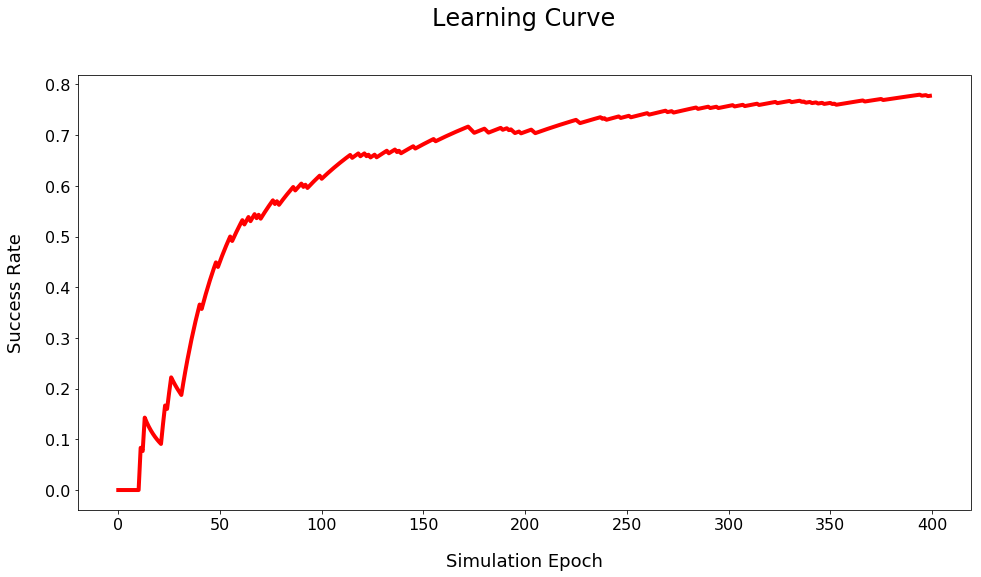

In [22]:
draw_learning_curve(curve)

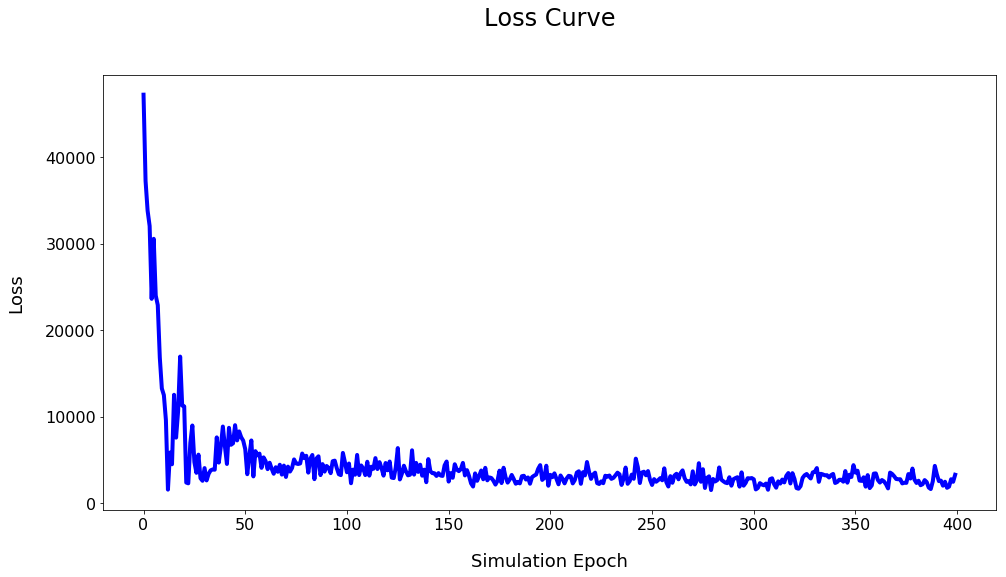

In [23]:
draw_loss_curve(losses)

In [ ]:
draw_loss_curve(losses[-100:])

In [24]:
saver = tf.train.Saver()

In [27]:
saver.save(agent.model.sess, "trained_model/tf_400/", global_step = 400)  

'trained_model/tf_400/-400'